In [51]:
# Librerías Necesarias

# Preprocesamiento de Datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Métricas de Evaluación
from sklearn.metrics import mean_squared_error, r2_score

# Modelado con TensorFlow y Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Guardado y Carga de Modelos
import joblib

# Visualización
import matplotlib.pyplot as plt

# Sistema Operativo
import os

In [52]:
# Rutas de Datos
ruta_train_csv = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train.csv'
ruta_test_csv = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test.csv'
ruta_train_img = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train'
ruta_test_img = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test'

# Cargar Datos
df_train = pd.read_csv(ruta_train_csv)
df_test = pd.read_csv(ruta_test_csv)

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          15000 non-null  int64
 1   clip_count  15000 non-null  int64
dtypes: int64(2)
memory usage: 234.5 KB


In [54]:
df_train.describe()

,id,clip_count
count,15000.000000,15000.000000
mean,37500.500000,37.290133
std,4330.271354,21.922691
min,30001.000000,0.000000
25%,33750.750000,18.000000
50%,37500.500000,37.000000
75%,41250.250000,56.000000
max,45000.000000,75.000000


In [55]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      5000 non-null   int64
dtypes: int64(1)
memory usage: 39.2 KB


In [56]:
df_test.describe()

,id
count,5000.000000
mean,47500.500000
std,1443.520003
min,45001.000000
25%,46250.750000
50%,47500.500000
75%,48750.250000
max,50000.000000


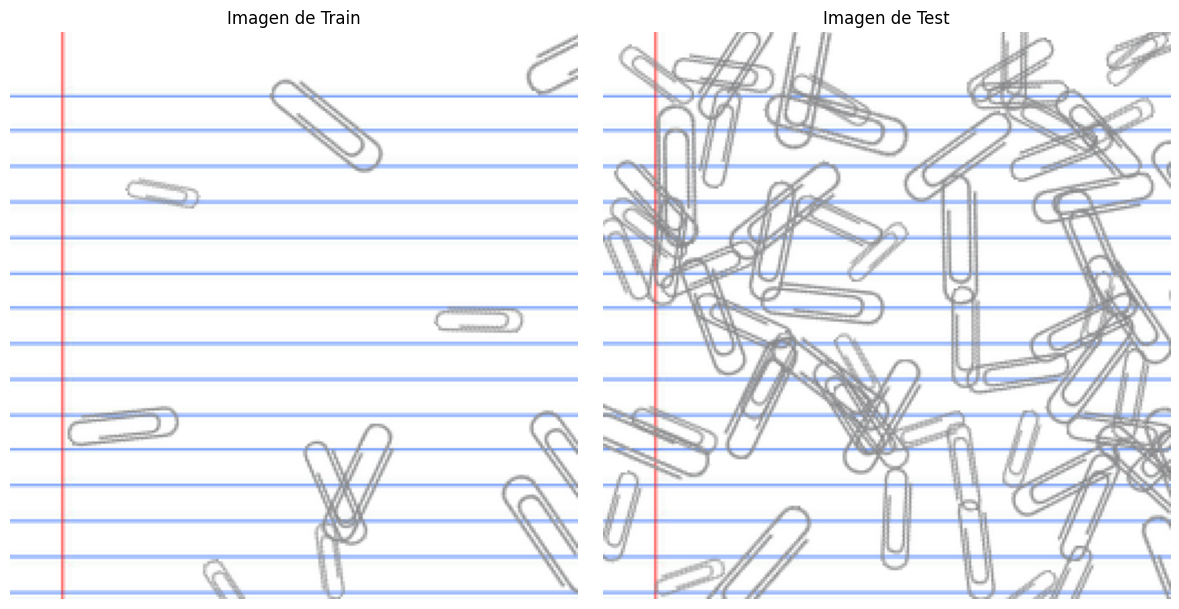

In [57]:
import cv2
import matplotlib.pyplot as plt
import os

# Función para mostrar una imagen
def mostrar_imagen(ruta_img, img_id, titulo):
    img_path = os.path.join(ruta_img, f"clips-{img_id}.png")
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(titulo)
    plt.axis('off')

# Visualizar imágenes de train y test
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Imagen de train
plt.subplot(1, 2, 1)
mostrar_imagen(ruta_train_img, img_id='30001', titulo='Imagen de Train')

# Imagen de test
plt.subplot(1, 2, 2)
mostrar_imagen(ruta_test_img, img_id='45001', titulo='Imagen de Test')

plt.tight_layout()
plt.show()


In [58]:
# Función para obtener información de una imagen
def obtener_info_imagen(ruta_img, img_id):
    img_path = os.path.join(ruta_img, f"clips-{img_id}.png")
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {img_path}")
    
    # Tipo de archivo
    extension = os.path.splitext(img_path)[-1]
    
    # Dimensiones de la imagen
    altura, anchura = img.shape[:2]
    
    # Tipo de color
    if len(img.shape) == 3:
        canales = img.shape[2]
        tipo_color = "Color (RGB)" if canales == 3 else "Escala de Grises con Alfa"
    else:
        tipo_color = "Escala de Grises"
    
    # Mostrar resultados
    print(f"Información de la imagen: {img_path}")
    print(f"- Dimensiones: {anchura} x {altura}")
    print(f"- Tipo de archivo: {extension}")
    print(f"- Tipo de color: {tipo_color}")

# Mostrar información de una imagen de entrenamiento y una de prueba
print("Imagen de Entrenamiento:")
obtener_info_imagen(ruta_train_img, img_id='30001')

print("\nImagen de Prueba:")
obtener_info_imagen(ruta_test_img, img_id='45001')


Imagen de Entrenamiento:
Información de la imagen: C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train\clips-30001.png
- Dimensiones: 256 x 256
- Tipo de archivo: .png
- Tipo de color: Color (RGB)

Imagen de Prueba:
Información de la imagen: C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test\clips-45001.png
- Dimensiones: 256 x 256
- Tipo de archivo: .png
- Tipo de color: Color (RGB)


In [59]:
# ✅ Parámetros Globales optimizados para CPU
IMG_SIZE = (128, 128)  # Mantén el tamaño si el rendimiento es aceptable
BATCH_SIZE = 16        # Reduce el tamaño del lote para evitar sobrecarga en CPU
EPOCHS = 30            # Menor cantidad de épocas para evitar tiempos de entrenamiento excesivos
COLOR_MODE = 'grayscale'  # Imágenes en escala de grises
AUTOTUNE = tf.data.AUTOTUNE

In [60]:
# ✅ Rutas de Datos
ruta_train_csv = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train.csv'
ruta_test_csv = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test.csv'
ruta_train_img = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train'
ruta_test_img = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test'

# ✅ Cargar Datos
df_train = pd.read_csv(ruta_train_csv)
df_test = pd.read_csv(ruta_test_csv)

# ✅ Preprocesamiento de Imágenes optimizado para CPU
def cargar_datos(df, ruta_img, es_entrenamiento=True):
    ids = df['id'].values
    labels = df['clip_count'].values if 'clip_count' in df.columns else None
    
    def preprocesar_imagen(id, label=None):
        img_path = tf.strings.join([ruta_img, "/clips-", tf.strings.as_string(id), ".png"])
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, IMG_SIZE)
        img = img / 255.0
        return (img, tf.cast(label, tf.float32)) if label is not None else img
    
    dataset = tf.data.Dataset.from_tensor_slices((ids, labels) if es_entrenamiento else ids)
    dataset = dataset.map(
        lambda id, label=None: preprocesar_imagen(id, label),
        num_parallel_calls=AUTOTUNE
    )
    dataset = dataset.cache()  # Evita recargar imágenes en cada época
    if es_entrenamiento:
        dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    
    return dataset

# ✅ Crear Datasets
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=42)
dataset_train = cargar_datos(df_train, ruta_train_img, es_entrenamiento=True)
dataset_val = cargar_datos(df_val, ruta_train_img, es_entrenamiento=True)
dataset_test = cargar_datos(df_test, ruta_test_img, es_entrenamiento=False)

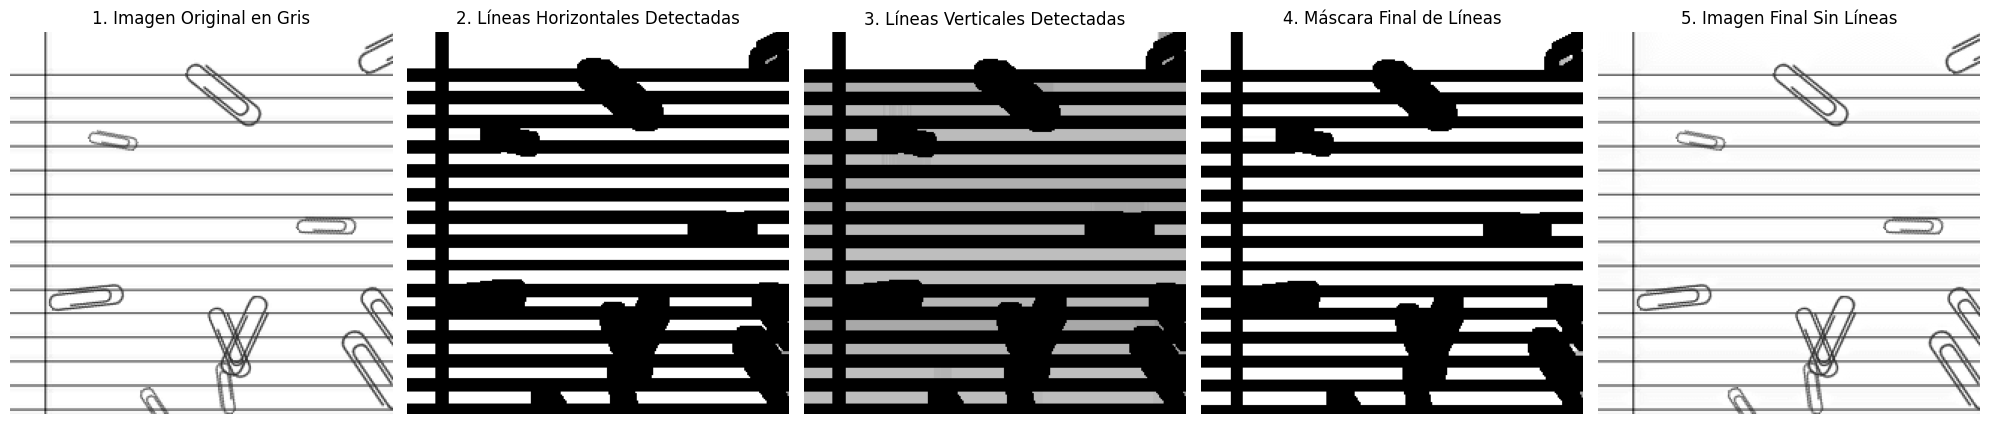

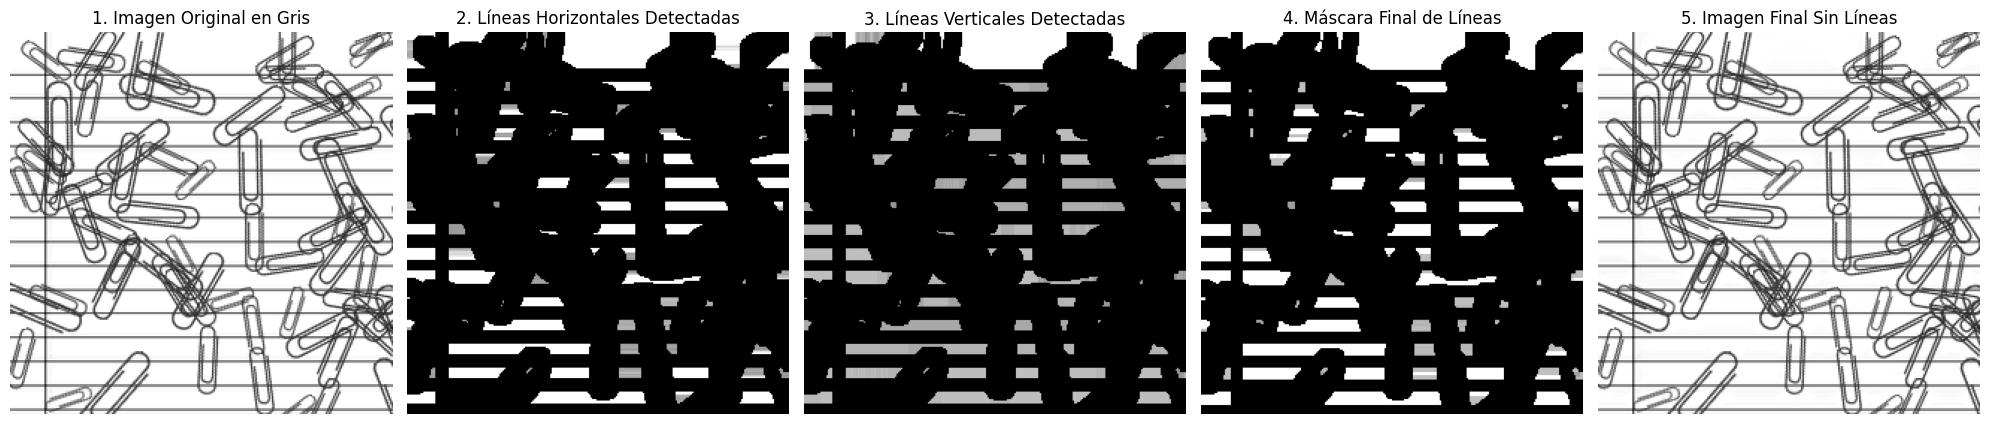

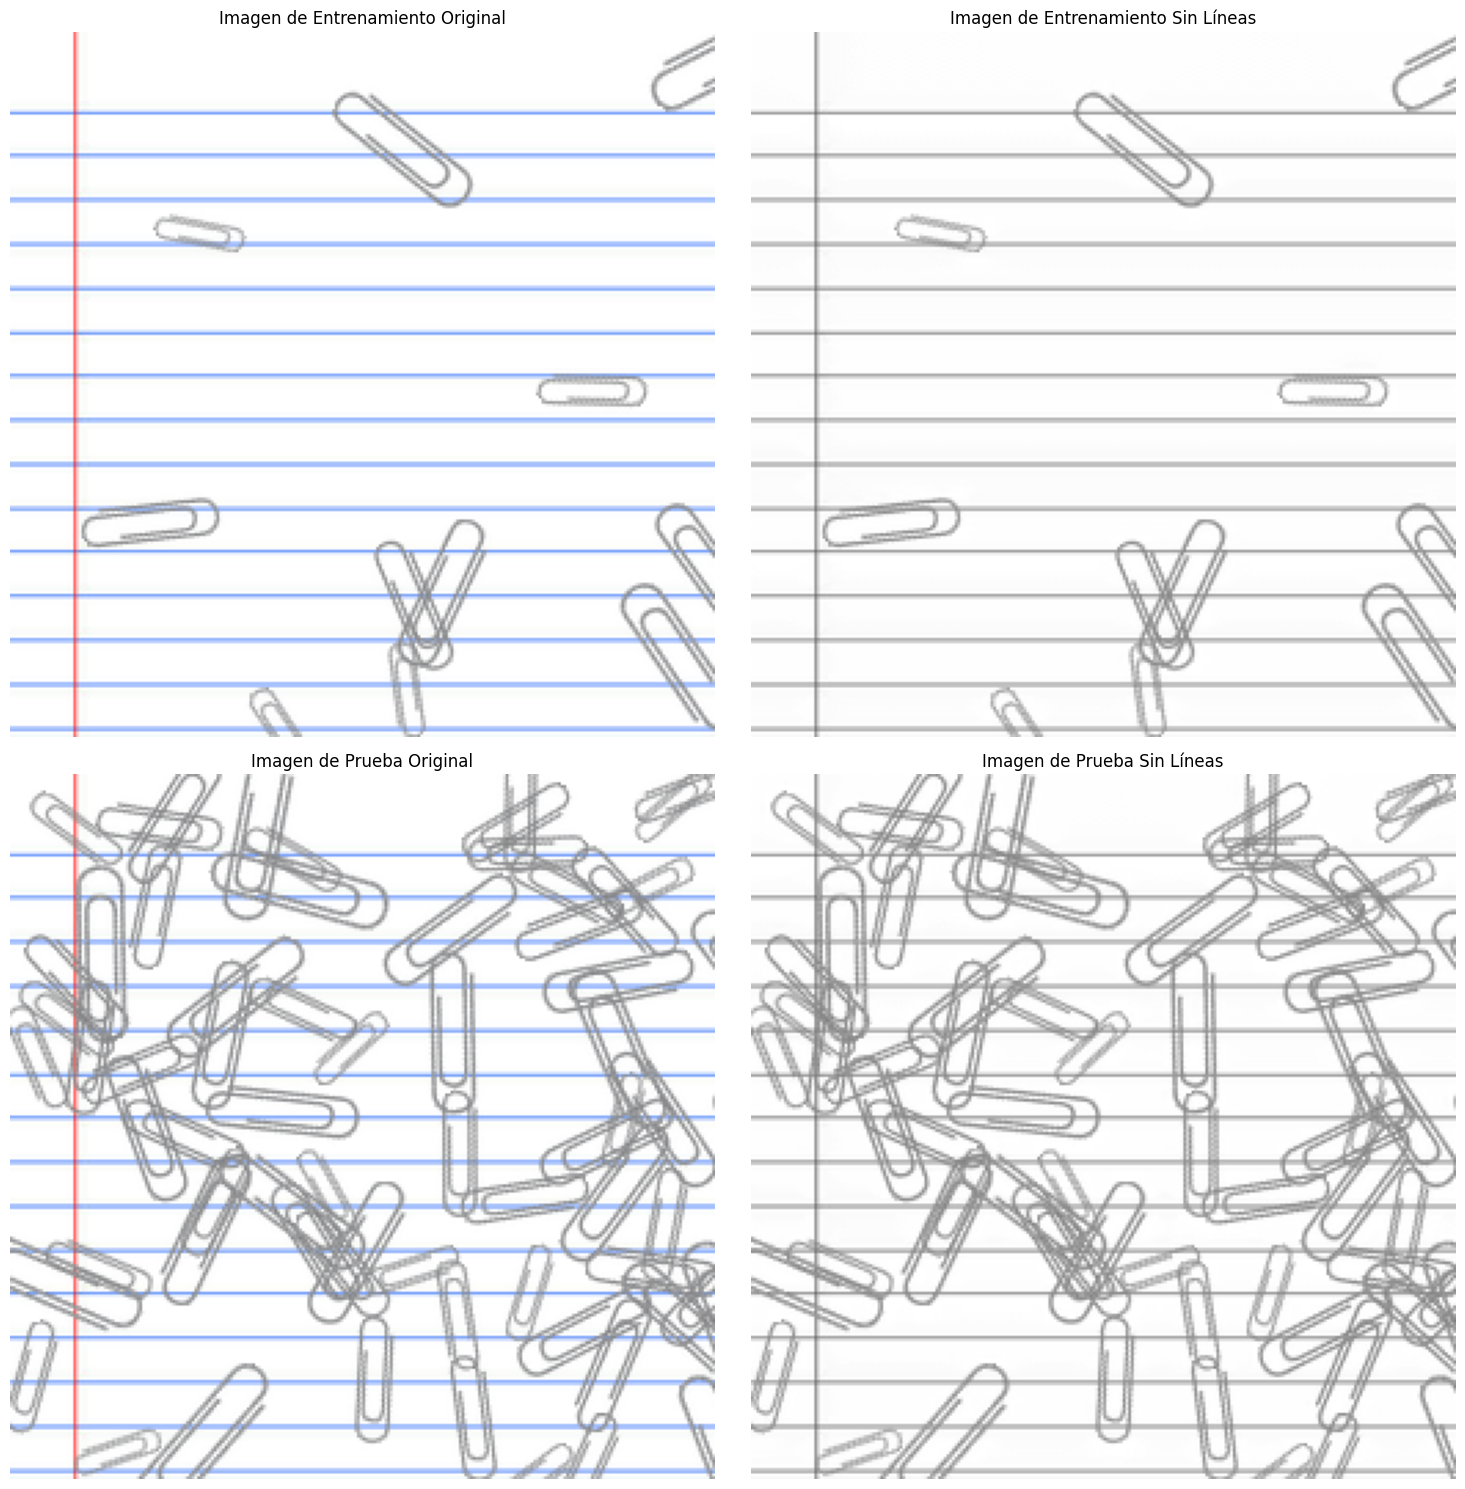

In [67]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def eliminar_lineas_protegiendo_clips(ruta_imagen):
    # Cargar la imagen
    imagen = cv2.imread(ruta_imagen, cv2.IMREAD_UNCHANGED)
    if imagen is None:
        raise FileNotFoundError(f"No se pudo cargar la imagen: {ruta_imagen}")
    
    # Eliminar canal alfa si existe
    if imagen.shape[-1] == 4:
        imagen = imagen[:, :, :3]
    
    # Convertir a escala de grises
    gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    # Detección de bordes para clips
    bordes_clips = cv2.Canny(gris, 50, 150)
    bordes_clips_dilatados = cv2.dilate(bordes_clips, np.ones((3, 3), np.uint8), iterations=3)
    mascara_clips = cv2.bitwise_not(bordes_clips_dilatados)
    
    # 1️⃣ Detección de Líneas Horizontales
    kernel_horizontal = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    lineas_horizontales = cv2.morphologyEx(gris, cv2.MORPH_OPEN, kernel_horizontal)
    lineas_horizontales = cv2.bitwise_and(lineas_horizontales, mascara_clips)
    
    # 2️⃣ Detección de Líneas Verticales
    kernel_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 25))
    lineas_verticales = cv2.morphologyEx(gris, cv2.MORPH_OPEN, kernel_vertical)
    lineas_verticales = cv2.bitwise_and(lineas_verticales, mascara_clips)
    
    # 3️⃣ Crear una máscara final de líneas
    mascara_lineas = cv2.bitwise_or(lineas_horizontales, lineas_verticales)
    
    # 4️⃣ Dilatar ligeramente la máscara final
    mascara_lineas = cv2.dilate(mascara_lineas, np.ones((2, 2), np.uint8), iterations=1)
    
    # 5️⃣ Interpolar para eliminar las líneas
    imagen_limpia = cv2.inpaint(gris, mascara_lineas, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    
    # 🔍 Visualizar Resultados Intermedios
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    
    axs[0].imshow(gris, cmap='gray')
    axs[0].set_title('1. Imagen Original en Gris')
    axs[0].axis('off')
    
    axs[1].imshow(lineas_horizontales, cmap='gray')
    axs[1].set_title('2. Líneas Horizontales Detectadas')
    axs[1].axis('off')
    
    axs[2].imshow(lineas_verticales, cmap='gray')
    axs[2].set_title('3. Líneas Verticales Detectadas')
    axs[2].axis('off')
    
    axs[3].imshow(mascara_lineas, cmap='gray')
    axs[3].set_title('4. Máscara Final de Líneas')
    axs[3].axis('off')
    
    axs[4].imshow(imagen_limpia, cmap='gray')
    axs[4].set_title('5. Imagen Final Sin Líneas')
    axs[4].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB), cv2.cvtColor(imagen_limpia, cv2.COLOR_GRAY2RGB)

# Rutas de las imágenes
ruta_entrenamiento = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\train\clips-30001.png'
ruta_prueba = r'C:\Users\mikel\OneDrive\Documentos\TB-DS-BIO-23.09.24\REPOSITORIOS\Mikel\clip_count\test\clips-45001.png'

# Procesar imágenes
img_entrenamiento, resultado_entrenamiento = eliminar_lineas_protegiendo_clips(ruta_entrenamiento)
img_prueba, resultado_prueba = eliminar_lineas_protegiendo_clips(ruta_prueba)

# Visualizar las imágenes finales
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

axs[0, 0].imshow(img_entrenamiento)
axs[0, 0].set_title('Imagen de Entrenamiento Original')
axs[0, 0].axis('off')

axs[0, 1].imshow(resultado_entrenamiento)
axs[0, 1].set_title('Imagen de Entrenamiento Sin Líneas')
axs[0, 1].axis('off')

axs[1, 0].imshow(img_prueba)
axs[1, 0].set_title('Imagen de Prueba Original')
axs[1, 0].axis('off')

axs[1, 1].imshow(resultado_prueba)
axs[1, 1].set_title('Imagen de Prueba Sin Líneas')
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [51]:
# ✅ Definir el Modelo CNN optimizado para CPU
def crear_modelo():
    modelo = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        Flatten(),
        Dense(128, activation='relu'),  # Reduce la cantidad de neuronas
        Dropout(0.5),
        Dense(1, activation='linear')  # Salida de regresión
    ])
    
    modelo.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return modelo

# ✅ Crear Modelo
modelo = crear_modelo()
modelo.summary()

C:\Users\mikel\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,089 (12.61 MB)

 Trainable params: 3,304,641 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 178s 233ms/step - loss: 280.4232 - rmse: 15.9230 - val_loss: 244.7247 - val_rmse: 15.6437 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 228s 304ms/step - loss: 132.2562 - rmse: 11.4985 - val_loss: 370.3871 - val_rmse: 19.2454 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 232s 309ms/step - loss: 109.8862 - rmse: 10.4807 - val_loss: 487.8449 - val_rmse: 22.0872 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 223s 297ms/step - loss: 111.2292 - rmse: 10.5449 - val_loss: 41.3170 - val_rmse: 6.4278 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 229s 305ms/step - loss: 112.1038 - rmse: 10.5860 - val_loss: 16.3008 - val_rmse: 4.0374 - learning_rate: 0.0010
Epoch 6/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 221s 294ms/step - loss: 108.7835 - rmse: 10.4284 - val_loss: 39.9709 - val_rmse: 6.3223 - learning_rate: 0.0010
Epoch 7/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 230s 307ms/step - loss: 101.5463 - rmse: 1

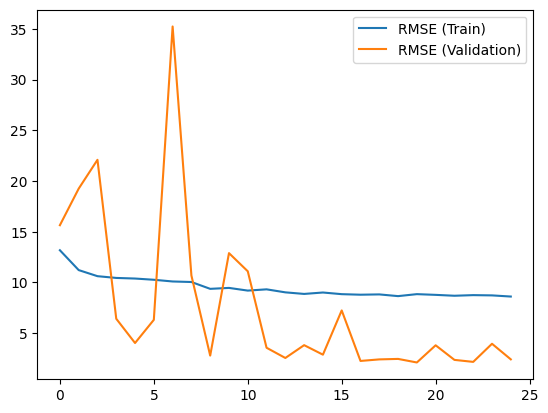

In [52]:
# ✅ Callbacks optimizados
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=3)

# ✅ Entrenar Modelo
historial = modelo.fit(
    dataset_train,
    validation_data=dataset_val,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

# ✅ Graficar Métricas
plt.plot(historial.history['rmse'], label='RMSE (Train)')
plt.plot(historial.history['val_rmse'], label='RMSE (Validation)')
plt.legend()
plt.show()

In [53]:
# ✅ Evaluación
train_loss, train_rmse = modelo.evaluate(dataset_train)
val_loss, val_rmse = modelo.evaluate(dataset_val)
print(f"🔹 RMSE (Train): {train_rmse:.2f}")
print(f"🔹 RMSE (Validation): {val_rmse:.2f}")

# ✅ Predicciones
predicciones = modelo.predict(dataset_test).flatten()
df_test['clip_count'] = np.round(predicciones).astype(int)

# ✅ Guardar Resultados
df_test[['id', 'clip_count']].to_csv('submission.csv', index=False)
print("✅ Archivo 'submission.csv' generado correctamente.")

750/750 ━━━━━━━━━━━━━━━━━━━━ 52s 70ms/step - loss: 3.5887 - rmse: 1.8941
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 4.5850 - rmse: 2.1409
🔹 RMSE (Train): 1.88
🔹 RMSE (Validation): 2.12
313/313 ━━━━━━━━━━━━━━━━━━━━ 30s 97ms/step
✅ Archivo 'submission_p.csv' generado correctamente.


In [54]:
# ✅ Guardar el Modelo en la Carpeta 'modelo_final'
ruta_modelo_completo = os.path.join('modelo_final', 'modelo_clip_count_p.h5')
modelo.save(ruta_modelo_completo)
print(f"✅ Modelo guardado en '{ruta_modelo_completo}'")

✅ Modelo guardado en 'modelo_final\modelo_clip_count_p.h5'
